This is a replication of Richman and Wuthrich's 2019 paper: A neural network extension of the Lee-Carter model to multiple populations


In [5]:
#!pip install keras
#!pip install tensorflow
#!pip install pandas
#!pip install matplotlib
#!pip install scikit-learn
import keras
import numpy as np
import pandas as pd
import os as os
import matplotlib.pyplot as plt
from keras.layers import Input, Embedding, Flatten, Dense, BatchNormalization, Dropout, concatenate
from keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [64]:
# read in data
print(os.getcwd())
path = "../data/Mx_1x1/"
file = "hmd.csv"
data = pd.read_csv(path + file)

data['Age'] = pd.to_numeric(data['Age'], errors='coerce')
data['Mortality_rate'] = pd.to_numeric(data['Mortality_rate'], errors='coerce')
default_int_value = 110
data['Age'].fillna(default_int_value, inplace=True)

print(data)
print(data.dtypes)

/Users/paigepark/Desktop/deep-mortality/code
        Year    Age Country  Gender  Mortality_rate
0       1921    0.0     AUS  Female        0.059987
1       1921    1.0     AUS  Female        0.012064
2       1921    2.0     AUS  Female        0.005779
3       1921    3.0     AUS  Female        0.002889
4       1921    4.0     AUS  Female        0.003254
...      ...    ...     ...     ...             ...
889771  2021  106.0     USA    Male        0.620555
889772  2021  107.0     USA    Male        0.493481
889773  2021  108.0     USA    Male        0.536300
889774  2021  109.0     USA    Male        0.560538
889775  2021  110.0     USA    Male        0.338811

[889776 rows x 5 columns]
Year                int64
Age               float64
Country            object
Gender             object
Mortality_rate    float64
dtype: object


I need to do some light data cleaning to make the data the same as Richman and Wuthrich. First, I need to get rid of all mortality rates above age 99 and all years prior to 1950. I also replace missing mortality rates with the average rates across all other countries for the same gender, as Richman and Wuthrich do. There are only seven missing values in the entire training set. 

In [65]:
# removing observations above age 100 and prior to 1950
df_99 = data[data['Age'] < 100]
df = df_99[df_99['Year'] > 1949]
#print(df)

# look at missing mort rates 
missing_age_df = df[df['Mortality_rate'].isna()]
print(missing_age_df)

# Calculate the average mortality rate for the same year and gender, excluding the NaN values.
avg_mortality = df.groupby(['Year', 'Gender'])['Mortality_rate'].transform(lambda x: x.fillna(x.mean()))

# Replace NaN values in the original Mortality_rate column with the computed averages.
df['Mortality_rate'] = df['Mortality_rate'].fillna(avg_mortality)

# make sure no missing
missing_age_df = df[df['Mortality_rate'].isna()]
print(missing_age_df)

# encode categorical variables 

country_encoder = LabelEncoder()
gender_encoder = LabelEncoder()

df['Country'] = country_encoder.fit_transform(df['Country'])
df['Gender'] = gender_encoder.fit_transform(df['Gender'])

#df['Country'] = to_categorical(df['Country'])
#df['Gender'] = to_categorical(df['Gender'])
#df['Age'] = to_categorical(df['Age'])

# setting correct data types for age and year
df['Age'] = df['Age'].astype('int32')
df['Year'] = df['Year'].astype('float32')

print(df.dtypes)

        Year   Age Country Gender  Mortality_rate
696069  1952  99.0     ISL   Male             NaN
739359  1960  99.0     LUX   Male             NaN
739470  1961  99.0     LUX   Male             NaN
739690  1963  97.0     LUX   Male             NaN
739802  1964  98.0     LUX   Male             NaN
739914  1965  99.0     LUX   Male             NaN
740247  1968  99.0     LUX   Male             NaN
Empty DataFrame
Columns: [Year, Age, Country, Gender, Mortality_rate]
Index: []
Year              float32
Age                 int32
Country             int64
Gender              int64
Mortality_rate    float64
dtype: object


/var/folders/1z/wn6shwbs4_9gcwtsrgz8v5vc0000gn/T/ipykernel_61625/4183681102.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mortality_rate'] = df['Mortality_rate'].fillna(avg_mortality)
/var/folders/1z/wn6shwbs4_9gcwtsrgz8v5vc0000gn/T/ipykernel_61625/4183681102.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Country'] = country_encoder.fit_transform(df['Country'])
/var/folders/1z/wn6shwbs4_9gcwtsrgz8v5vc0000gn/T/ipykernel_61625/4183681102.py:26: SettingWithCopyWarning: 
A value is trying t

Below, I split the data into training and test sets according to Richman and Wuthrich's process. The round 1 training set includes includes data from 1950 to 1990 and the test set consists of data from 1991 to 1999. The round 2 training set includes data from 1950 to 1999 and the test set consists of data from 2000 to 2016. Each of the training sets have 5% of the data used as validation sets. 

In [66]:
# splitting the data 
train = df[df['Year'] < 2000]
test = df[df['Year'] >= 2000]

# splitting into round 1 and round 2 sets
train_1 = train[train['Year'] <= 1990]
test_1 = train[train['Year'] > 1990]

train_2 = train
test_2 = test

# split training and test sets 1 by Xs and y
x_train1_year = np.array(train_1['Year'])
x_train1_age = np.array(train_1['Age'])
x_train1_country = np.array(train_1['Country'])
x_train1_gender = np.array(train_1['Gender'])
y_train1 = np.array(train_1['Mortality_rate'])

x_test1_year = np.array(test_1['Year'])
x_test1_age = np.array(test_1['Age'])
x_test1_country = np.array(test_1['Country'])
x_test1_gender = np.array(test_1['Gender'])
y_test1 = np.array(test_1['Mortality_rate'])

# split training and test sets 2 by X and y
x_train2 = train_2.drop('Mortality_rate', axis=1)
y_train2 = train_2['Mortality_rate']

x_test2 = test_2.drop('Mortality_rate', axis=1)
y_test2 = test_2['Mortality_rate']

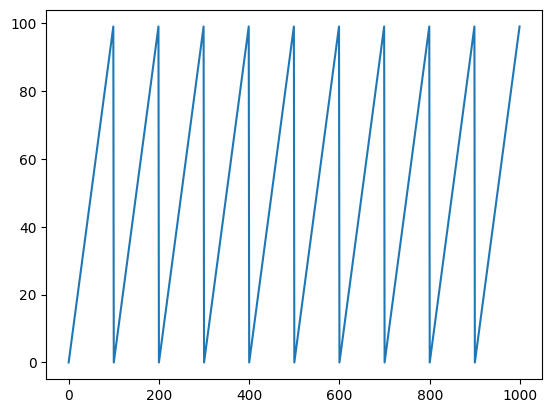

In [67]:
plt.plot(x_train1_age[:1000])

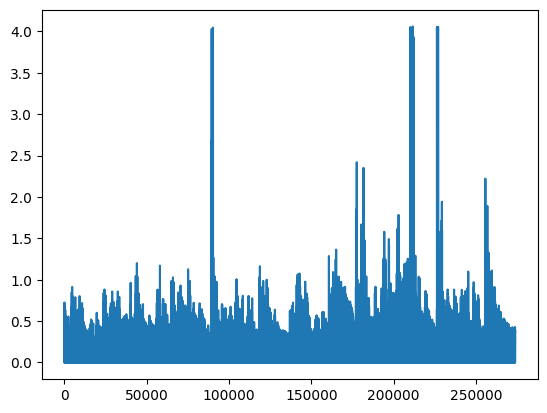

In [68]:
plt.plot(y_train1)

In [50]:
# normalize year feature
x_train1_year = (x_train1_year - x_train1_year.min())
x_train1_year = x_train1_year / x_train1_year.max()

x_test1_year = (x_test1_year - x_test1_year.min())
x_test1_year = x_test1_year / x_test1_year.max()

Below I normalize the outputs by setting all outputs greater than 1 to 1. At older ages its possible to get mortality rates higher than 1. In HMD life tables, this is accounted for by used sophisticated smoothing procedures. I'm using the raw death rates here, so for now, I'm just truncating mortality rates higher than 1. I'll come back and fix this later.

In [69]:
# normalize outputs
y_train1[y_train1 > 1] = 1
y_test1[y_test1 > 1] = 1

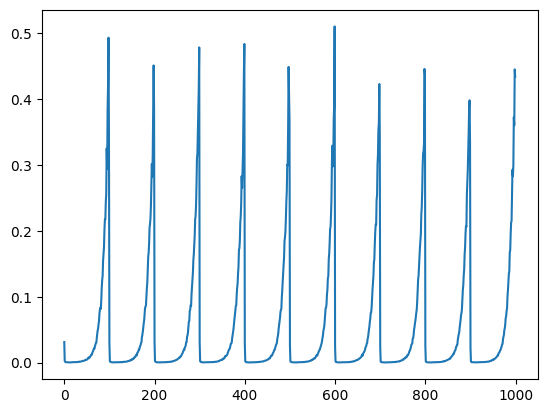

In [78]:
plt.plot(y_train1[20000:21000])

Defining inputs and embedding layers

In [83]:
# defining inputs 
Year = Input(shape=(1,), dtype='float32', name='Year')
Age =  Input(shape=(1,), dtype='int32', name='Age')
Country = Input(shape=(1,), dtype='int32', name='Country')
Gender = Input(shape=(1,), dtype='int32', name='Gender')

# defining embedding layers 
Age_embed = Embedding(input_dim=100, output_dim=5, input_length=1, name='Age_embed')(Age)
Age_embed = Flatten()(Age_embed)

Gender_embed = Embedding(input_dim=2, output_dim=5, input_length=1, name='Gender_embed')(Gender)
Gender_embed = Flatten()(Gender_embed)

Country_embed = Embedding(input_dim=38, output_dim=5, input_length=1, name='Country_embed')(Country)
Country_embed = Flatten()(Country_embed)

# create feature vector 
features = concatenate([Year, Age_embed, Gender_embed, Country_embed])

In [84]:
# setting up middle layers 
middle = Dense(128, activation='tanh')(features)
middle = BatchNormalization()(middle)
middle = Dropout(0.05)(middle)

middle = Dense(128, activation='tanh')(middle)
middle = BatchNormalization()(middle)
middle = Dropout(0.05)(middle)

middle = Dense(128, activation='tanh')(middle)
middle = BatchNormalization()(middle)
middle = Dropout(0.05)(middle)

middle = Dense(128, activation='tanh')(middle)
middle = BatchNormalization()(middle)
middle = Dropout(0.05)(middle)

# setting up output layer 
main_output = concatenate([features, middle])
main_output = Dense(128, activation='tanh')(main_output)
main_output = BatchNormalization()(main_output)
main_output = Dropout(0.05)(main_output)
main_output = Dense(1, activation='sigmoid', name='main_output')(main_output)

# creating the model 
model = Model(inputs=[Year, Age, Country, Gender], outputs=[main_output])

# model summary
#model.summary()

In [85]:
# compiling the model
model.compile(loss='mse', optimizer='adam')

In [86]:
# fitting the model
fit = model.fit([x_train1_year, x_train1_age, x_train1_country, x_train1_gender], y_train1, epochs=50, batch_size=256, validation_split=0.05, verbose=2, shuffle=True)

Epoch 1/50
1017/1017 - 6s - loss: 0.0202 - val_loss: 0.0133 - 6s/epoch - 5ms/step
Epoch 2/50
1017/1017 - 5s - loss: 0.0137 - val_loss: 0.0118 - 5s/epoch - 5ms/step
Epoch 3/50
1017/1017 - 5s - loss: 0.0137 - val_loss: 0.0118 - 5s/epoch - 5ms/step
Epoch 4/50
1017/1017 - 5s - loss: 0.0137 - val_loss: 0.0118 - 5s/epoch - 5ms/step
Epoch 5/50
1017/1017 - 5s - loss: 0.0137 - val_loss: 0.0118 - 5s/epoch - 5ms/step
Epoch 6/50
1017/1017 - 5s - loss: 0.0137 - val_loss: 0.0136 - 5s/epoch - 5ms/step
Epoch 7/50
1017/1017 - 5s - loss: 0.0137 - val_loss: 0.0118 - 5s/epoch - 5ms/step
Epoch 8/50
1017/1017 - 5s - loss: 0.0137 - val_loss: 0.0118 - 5s/epoch - 5ms/step
Epoch 9/50
1017/1017 - 5s - loss: 0.0137 - val_loss: 0.0118 - 5s/epoch - 5ms/step
Epoch 10/50
1017/1017 - 5s - loss: 0.0137 - val_loss: 0.0118 - 5s/epoch - 5ms/step
Epoch 11/50
1017/1017 - 5s - loss: 0.0137 - val_loss: 0.0118 - 5s/epoch - 5ms/step
Epoch 12/50
1017/1017 - 5s - loss: 0.0137 - val_loss: 0.0126 - 5s/epoch - 5ms/step
Epoch 13/50
1

In [87]:
predictions = model.predict([X_train1_year[0:500], X_train1_age[0:500], X_train1_country[0:500], X_train1_gender[0:500]])

16/16 [==============================] - 0s 898us/step


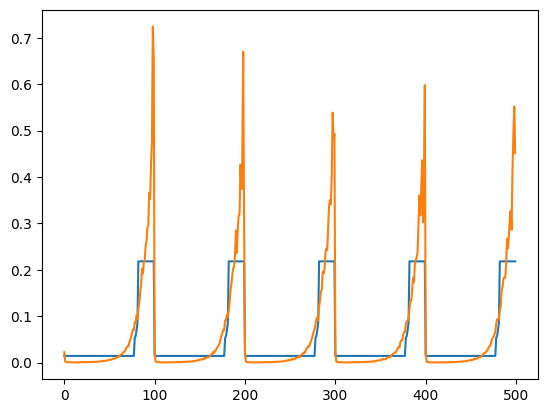

In [88]:
plt.plot(predictions)
plt.plot(y_train1[0:500])

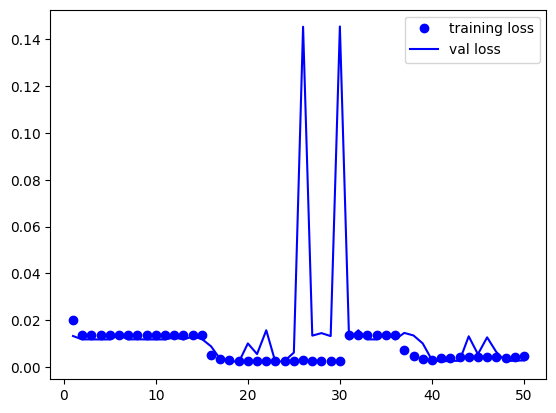

In [89]:
history = fit.history
loss_values = history["loss"]
val_loss_values = history["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label = "training loss")
plt.plot(epochs, val_loss_values, "b", label = "val loss")
plt.legend()
plt.show()